In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets 
import torchvision.transforms as transforms

In [2]:
input_size = 784        #Number of input neurons (image pixels, 28x28)
hidden_size0 = 32
hidden_size1 = 16      #Number of hidden neurons
out_size = 10           #Number of classes (0-9) 
epochs = 10            #How many times we pass our entire dataset into our network 
batch_size = 64        #Input size of the data during one iteration 
learning_rate = 0.001   #How fast we are learning

In [ ]:
train_dataset = datasets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size0, hidden_size1, out_size):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_size0)     #784 - 128
        self.fc1 = nn.Linear(hidden_size0, hidden_size1)   #128 - 64
        self.fc2 = nn.Linear(hidden_size1, out_size)       #64 - 10
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.fc0.weight) #only works with ReLU
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)

    def forward(self, x):
        out = self.relu(self.fc0(x))
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [22]:
#Create an object of the class, which represents our network 
net = Net(input_size, hidden_size0, hidden_size1, out_size)
CUDA = torch.cuda.is_available()
if CUDA:
    net = net.cuda()
#The loss function. The Cross Entropy loss comes along with Softmax. Therefore, no need to specify Softmax as well
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [23]:
print(CUDA)

True


In [ ]:
#Training
for epoch in range(epochs):
    correct_train = 0
    running_loss = 0
    for i, (images, labels) in enumerate(train_loader):   
        #(batch,1,28,28)
        images = images.view(-1, 28*28)    
        if CUDA:
            images = images.cuda()
            labels = labels.cuda()
            
        outputs = net(images)       
        _, predicted = torch.max(outputs.data, 1)                                              
        correct_train += (predicted == labels).sum() 
        loss = criterion(outputs, labels)                 
        running_loss += loss.item()
        optimizer.zero_grad() 
        loss.backward()                                   
        optimizer.step()                                  
        
    print('Epoch [{}/{}], Training Loss: {:.3f}, Training Accuracy: {:.3f}%'.format
          (epoch+1, epochs, running_loss/len(train_loader), (100*correct_train.double()/len(train_dataset))))
print("DONE TRAINING!")

torch.save(net.state_dict(), f'model_inst_4.pth') #'binary_ffn_all.pth')


Epoch [1/10], Training Loss: 0.411, Training Accuracy: 88.275%
Epoch [2/10], Training Loss: 0.197, Training Accuracy: 94.380%
Epoch [3/10], Training Loss: 0.158, Training Accuracy: 95.377%
Epoch [4/10], Training Loss: 0.135, Training Accuracy: 95.993%
Epoch [5/10], Training Loss: 0.120, Training Accuracy: 96.413%
Epoch [6/10], Training Loss: 0.108, Training Accuracy: 96.805%
Epoch [7/10], Training Loss: 0.098, Training Accuracy: 97.112%
Epoch [8/10], Training Loss: 0.090, Training Accuracy: 97.333%
Epoch [9/10], Training Loss: 0.084, Training Accuracy: 97.432%
Epoch [10/10], Training Loss: 0.079, Training Accuracy: 97.617%
DONE TRAINING!


In [ ]:
from scipy.ndimage import center_of_mass, shift
import torch.nn.functional as F
import torch

def preprocess_mnist_like(tensor):
    if tensor.ndim == 2:
        tensor = tensor.unsqueeze(0).unsqueeze(0)  #[1, 1, 28, 28]

    tensor = tensor / (tensor.max() + 1e-8)
    tensor = F.avg_pool2d(tensor, 3, stride=1, padding=1)
    img_np = tensor[0, 0].cpu().numpy()

    if img_np.sum() == 0:
        return tensor

    com = center_of_mass(img_np)
    if len(com) != 2 or any([x != x for x in com]):
        return tensor

    shift_y = int(round(14 - com[0]))
    shift_x = int(round(14 - com[1]))
    img_centered = shift(img_np, shift=(shift_y, shift_x), order=1, mode='constant', cval=0.0)

    tensor_centered = torch.tensor(img_centered).unsqueeze(0).unsqueeze(0).float()
    return tensor_centered



In [21]:
import pygame
import numpy as np
import torch.nn.functional as F

def draw_mnist_input(scale=20):
    pygame.init()
    size = 28
    window = pygame.display.set_mode((size*scale, size*scale))
    pygame.display.set_caption("Draw a digit (Press Enter to finish)")
    canvas = np.zeros((size, size), dtype=np.float32)

    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                break
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_RETURN:
                    running = False
                    break
            elif pygame.mouse.get_pressed()[0]:
                x, y = pygame.mouse.get_pos()
                grid_x, grid_y = x // scale, y // scale
                if 0 <= grid_x < size and 0 <= grid_y < size:
                    canvas[grid_y, grid_x] = 1.0
                    for dx in [-1, 0, 1]:
                        for dy in [-1, 0, 1]:
                            nx, ny = grid_x + dx, grid_y + dy
                            if 0 <= nx < size and 0 <= ny < size:
                                canvas[ny, nx] = max(canvas[ny, nx], 0.5)

        for y in range(size):
            for x in range(size):
                val = int(canvas[y, x] * 255)
                pygame.draw.rect(window, (val, val, val), (x*scale, y*scale, scale, scale))

        pygame.display.flip()

    pygame.quit()
    return torch.tensor(canvas).unsqueeze(0)


custom_tensor = draw_mnist_input()
input_tensor = preprocess_mnist_like(custom_tensor).cuda()
pred = net(input_tensor.view(1, -1))


pred

tensor([[ -1.7430,   0.9303,   3.5242,   5.3841, -13.8410,  -3.2975,  -7.9356,
          -2.8800,  -7.1683, -12.4873]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [13]:
with torch.no_grad():
    correct = 0
    for images, labels in test_loader:
        if CUDA:
            images = images.cuda()
            labels = labels.cuda()
        images = images.view(-1, 28*28)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / len(test_dataset)))

Accuracy of the network on the 10000 test images: 96.62 %


In [18]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.ndimage import gaussian_filter

In [21]:
"""layer_name = "fc1"
neuron_indices = []
for i in range(32):
    neuron_indices.append(i)
steps = 200
lr = 0.1
smoothing_sigma = 0.8

def get_activation(net, x, layer, neuron_idx):
    out1 = F.relu(net.fc1(x))
    out2 = F.relu(net.fc2(out1))
    out3 = F.relu(net.fc3(out2))
    if layer == "fc1":
        return out1[0, neuron_idx]
    elif layer == "fc2":
        return out2[0, neuron_idx]
    elif layer == "fc3":
        return out3[0, neuron_idx]
    else:
        raise ValueError("Invalid layer")

net.eval()
device = 'cuda' if CUDA else 'cpu'
images = []

for idx in neuron_indices:
    input_image = torch.randn(1, 784, requires_grad=True, device=device)
    optimizer = torch.optim.Adam([input_image], lr=lr)

    for step in range(steps):
        optimizer.zero_grad()
        activation = get_activation(net, input_image, layer_name, idx)
        loss = -activation
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            input_image.clamp_(0, 1)

    img_np = input_image.detach().cpu().view(28, 28).numpy()
    if smoothing_sigma > 0:
        img_np = gaussian_filter(img_np, sigma=smoothing_sigma) #to make smoother
    images.append(img_np)

#plotting
cols=6
img_size=28
n = len(images)
rows = math.ceil(n / cols)

plt.figure(figsize=(cols * 2.5, rows * 2.5))

for i, img in enumerate(images):
    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(img, cmap='gray')
    ax.set_title(f'n{neuron_indices[i]}', fontsize=8)
    ax.axis('off')

plt.suptitle(f'Activation Maximization - {layer_name}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()"""

'layer_name = "fc1"\nneuron_indices = []\nfor i in range(32):\n    neuron_indices.append(i)\nsteps = 200\nlr = 0.1\nsmoothing_sigma = 0.8\n\ndef get_activation(net, x, layer, neuron_idx):\n    out1 = F.relu(net.fc1(x))\n    out2 = F.relu(net.fc2(out1))\n    out3 = F.relu(net.fc3(out2))\n    if layer == "fc1":\n        return out1[0, neuron_idx]\n    elif layer == "fc2":\n        return out2[0, neuron_idx]\n    elif layer == "fc3":\n        return out3[0, neuron_idx]\n    else:\n        raise ValueError("Invalid layer")\n\nnet.eval()\ndevice = \'cuda\' if CUDA else \'cpu\'\nimages = []\n\nfor idx in neuron_indices:\n    input_image = torch.randn(1, 784, requires_grad=True, device=device)\n    optimizer = torch.optim.Adam([input_image], lr=lr)\n\n    for step in range(steps):\n        optimizer.zero_grad()\n        activation = get_activation(net, input_image, layer_name, idx)\n        loss = -activation\n        loss.backward()\n        optimizer.step()\n        with torch.no_grad():\n 

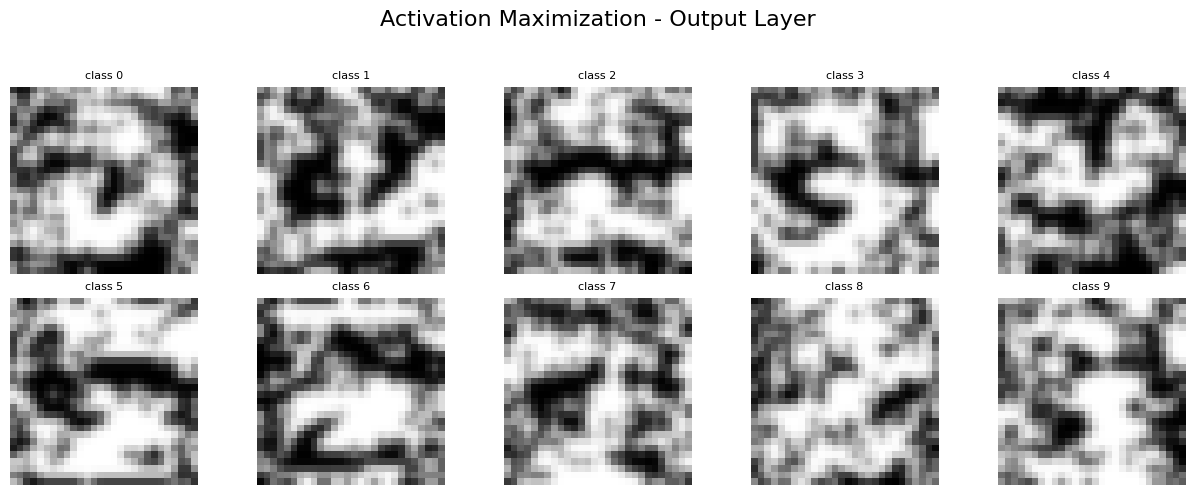

In [22]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.ndimage import gaussian_filter


layer_name = "output"
neuron_indices = list(range(10))
steps = 200
lr = 0.1
smoothing_sigma = 0.8

net.eval()
device = 'cuda' if CUDA else 'cpu'
images = []

for idx in neuron_indices:
    input_image = torch.randn(1, 784, requires_grad=True, device=device)
    optimizer = torch.optim.Adam([input_image], lr=lr)

    for step in range(steps):
        optimizer.zero_grad()
        logits = net(input_image)
        activation = logits[0, idx]
        loss = -activation
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            input_image.clamp_(0, 1)

    img_np = input_image.detach().cpu().view(28, 28).numpy()
    if smoothing_sigma > 0:
        img_np = gaussian_filter(img_np, sigma=smoothing_sigma)
    images.append(img_np)

#plotting
cols = 5
img_size = 28
n = len(images)
rows = math.ceil(n / cols)

plt.figure(figsize=(cols * 2.5, rows * 2.5))
for i, img in enumerate(images):
    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(img, cmap='gray')
    ax.set_title(f'class {neuron_indices[i]}', fontsize=8)
    ax.axis('off')

plt.suptitle(f'Activation Maximization - Output Layer', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
with torch.no_grad():
    correct = 0

    for images, labels in test_loader:
        if CUDA:
            images = images.cuda()
            labels = labels.cuda()
            
        images = images.view(-1, 28*28)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / len(test_dataset)))

Accuracy of the network on the 10000 test images: 96.6 %
